<a href="https://colab.research.google.com/github/SujayKrish03/Medical-image-classifier/blob/main/advertising_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib


In [2]:

# Step 2 — Load the Advertising dataset
# Option A: try to download a common mirror (works in Colab)
# Option B: if download fails, upload 'Advertising.csv' from your machine via the file chooser.

import io

url = 'https://raw.githubusercontent.com/selva86/datasets/master/Advertising.csv'  # common mirror
try:
    df = pd.read_csv(url, index_col=0)
    print('Loaded dataset from URL:', url)
except Exception as e:
    print('Could not download automatically. If you are in Colab, use the file upload dialog.')
    try:
        from google.colab import files
        uploaded = files.upload()
        key = next(iter(uploaded.keys()))
        df = pd.read_csv(io.BytesIO(uploaded[key]))
        print('Loaded uploaded file:', key)
    except Exception as ee:
        # fallback: construct a small sample dataset so the notebook still runs
        print('No file uploaded — using a small built-in sample so you can follow along.')
        df = pd.DataFrame({ 'TV':[230.1,44.5,17.2,151.5,180.8],
                            'Radio':[37.8,39.3,45.9,41.3,10.8],
                            'Newspaper':[69.2,45.1,69.3,58.5,58.4],
                            'Sales':[22.1,10.4,9.3,18.5,12.9] })
df.head()

Loaded dataset from URL: https://raw.githubusercontent.com/selva86/datasets/master/Advertising.csv


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
# Show all rows (or at least more than 5)
print(df)

# Or, to show the first 10 rows only:
df.head(10)

# See basic info: column names, non-null counts, data types
df.info()

# Quick summary stats (mean, min, max, etc.)
df.describe()


        TV  radio  newspaper  sales
1    230.1   37.8       69.2   22.1
2     44.5   39.3       45.1   10.4
3     17.2   45.9       69.3    9.3
4    151.5   41.3       58.5   18.5
5    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
196   38.2    3.7       13.8    7.6
197   94.2    4.9        8.1    9.7
198  177.0    9.3        6.4   12.8
199  283.6   42.0       66.2   25.5
200  232.1    8.6        8.7   13.4

[200 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [4]:

# Quick inspection
print('shape:', df.shape)
display(df.head())
display(df.describe())

shape: (200, 4)


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


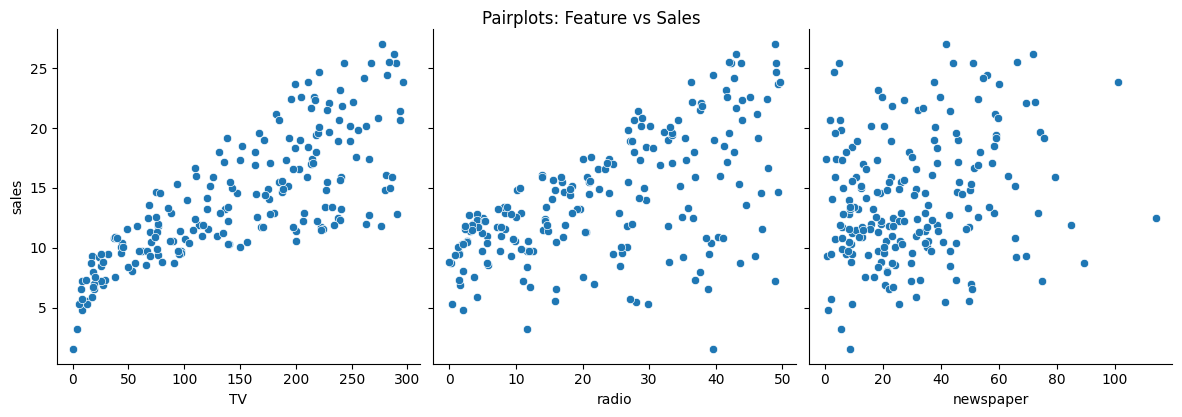

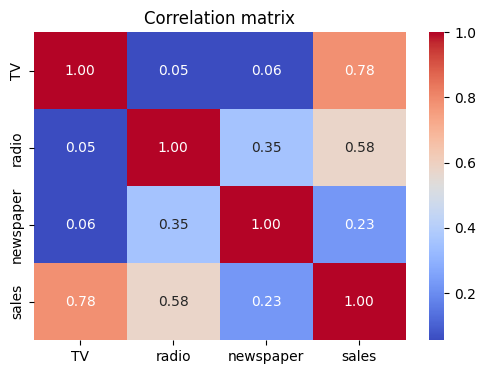

In [5]:

# Step 3 — EDA plots
sns.pairplot(df, x_vars=['TV','radio','newspaper'], y_vars='sales', height=4, kind='scatter')
plt.suptitle('Pairplots: Feature vs Sales', y=1.02)
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [6]:

# Step 4 — Train/test split
X = df[['TV','radio','newspaper']].values
y = df['sales'].values

# Keep a copy of column names for later
feature_names = ['TV','radio','newspaper']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape :', X_test.shape)

X_train shape: (160, 3)
X_test shape : (40, 3)


In [7]:

# Step 5 — Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

intercept = lr.intercept_
coefs = lr.coef_

print('Intercept:', intercept)
for name, c in zip(feature_names, coefs):
    print(f'Coefficient for {name}: {c:.6f}')

# Show the regression equation
terms = ' + '.join([f'({c:.6f} * {n})' for c,n in zip(coefs, feature_names)])
print('\nModel: Sales = {:.4f} + {}'.format(intercept, terms))

Intercept: 2.979067338122631
Coefficient for TV: 0.044730
Coefficient for radio: 0.189195
Coefficient for newspaper: 0.002761

Model: Sales = 2.9791 + (0.044730 * TV) + (0.189195 * radio) + (0.002761 * newspaper)


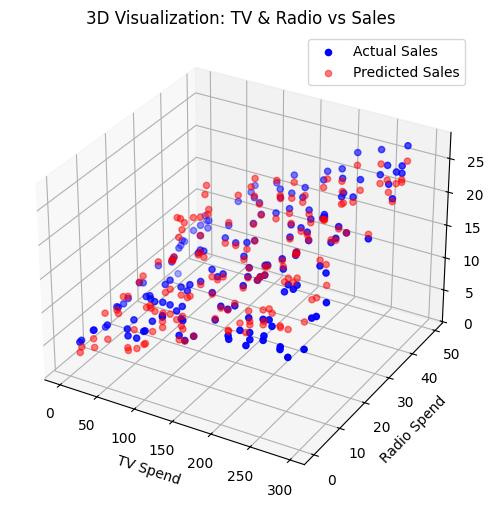

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Take TV and Radio as X and Y axes, Sales as Z
X1 = X_train[:, 0]  # TV
X2 = X_train[:, 1]  # Radio
y_actual = y_train   # Sales
y_pred = lr.predict(X_train)  # Predicted Sales

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Actual sales points
ax.scatter(X1, X2, y_actual, color='blue', label='Actual Sales')

# Predicted sales points (the plane)
ax.scatter(X1, X2, y_pred, color='red', alpha=0.5, label='Predicted Sales')

ax.set_xlabel('TV Spend')
ax.set_ylabel('Radio Spend')
ax.set_zlabel('Sales')
ax.set_title('3D Visualization: TV & Radio vs Sales')
ax.legend()
plt.show()


RMSE: 1.7816
R^2: 0.8994


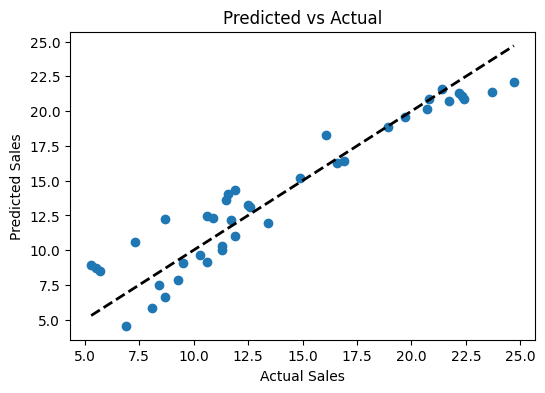

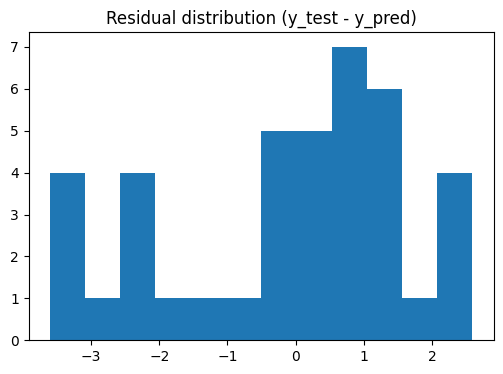

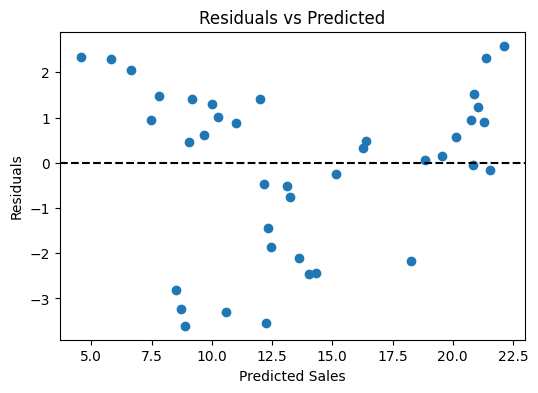

In [9]:

# Step 6 — Predict & evaluate
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

# Predicted vs Actual
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Predicted vs Actual')
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=12)
plt.title('Residual distribution (y_test - y_pred)')
plt.show()

# Residuals vs Predicted (check homoscedasticity)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

In [10]:

# Step 7 — OLS via statsmodels (to get p-values)
X_sm = sm.add_constant(X)  # add intercept
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           1.58e-96
Time:                        16:34:01   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [11]:

# Step 8 — VIF
X_vif = pd.DataFrame(X, columns=feature_names)
X_vif['Intercept'] = 1  # VIF implementation expects a constant term if using formula style
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

display(vif_data)

,feature,VIF
0,TV,1.004611
1,radio,1.144952
2,newspaper,1.145187
3,Intercept,6.848900


In [12]:

# Step 9 — Ridge & Lasso comparison (default alphas)
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1, max_iter=5000)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

def score_and_coefs(model, name):
    pred = model.predict(X_test)
    print(f'-- {name} --')
    print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
    print('R^2:', r2_score(y_test, pred))
    print('Coefs:', dict(zip(feature_names, model.coef_)))
    print()

score_and_coefs(ridge, 'Ridge (alpha=1.0)')
score_and_coefs(lasso, 'Lasso (alpha=0.1)')

-- Ridge (alpha=1.0) --
RMSE: 1.7815989481622216
R^2: 0.89943810463304
Coefs: {'TV': np.float64(0.04472953008891156), 'radio': np.float64(0.18918868583785295), 'newspaper': np.float64(0.002762870547339336)}

-- Lasso (alpha=0.1) --
RMSE: 1.7805959150767847
R^2: 0.8995513046486308
Coefs: {'TV': np.float64(0.0447196087642966), 'radio': np.float64(0.18881105938045872), 'newspaper': np.float64(0.0026270698094884846)}



In [13]:

# Step 10 — Polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
print('Polynomial feature names:', poly.get_feature_names_out(feature_names)[:10], '... total', X_poly.shape[1])

# Train/test split for polynomial features
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.2, random_state=42)
lr_poly = LinearRegression().fit(X_train_p, y_train_p)
y_pred_p = lr_poly.predict(X_test_p)
print('RMSE (poly degree 2):', np.sqrt(mean_squared_error(y_test_p, y_pred_p)))
print('R^2 (poly degree 2):', r2_score(y_test_p, y_pred_p))

Polynomial feature names: ['TV' 'radio' 'newspaper' 'TV^2' 'TV radio' 'TV newspaper' 'radio^2'
 'radio newspaper' 'newspaper^2'] ... total 9
RMSE (poly degree 2): 0.6425809120553604
R^2 (poly degree 2): 0.9869181490609605
